# ポアソンモデル
ビールの売り上げ数や生物の個体数など0以上の整数を取る離散型のデータは正規分布には従わず、ポアソン分布に従う。ポアソン分布のパラメータは期待値$\lambda$の一つであり、活性化関数は指数関数が用いられる。ここでは天気、気温を入力変数として目的変数である釣獲尾数を回帰するポアソンモデルを説明する。

## データの説明

In [216]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pymc as pm

In [217]:
fish_nums = pd.read_csv('../data/2-4-fish-num.csv')

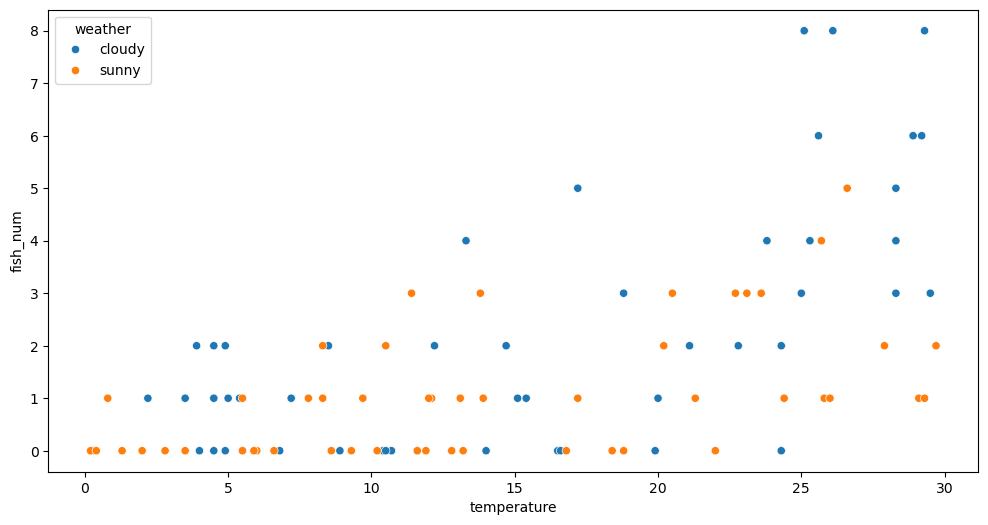

In [218]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='temperature', y='fish_num', data=fish_nums, hue="weather", ax=axes)
plt.show()

この図からは晴れの日より曇りの日の方がよく魚が釣れそうだということがわかる(実際、曇りの日は気圧が低く水圧も低くなるため魚の活性が上がるから釣れやすいと言われている)。では、それが本当かを確かめるため次のようなポアソンモデルでモデル化する。
$$
\lambda_i = \exp(w_0 + w_1x_{1i} + w_2x_{2i}) \\
y_i \sim Poisson(\lambda_i)
$$
入力変数の線形結合を指数関数によって非線形変換することで、ポアソン分布のパラメータ$\lambda$の取りうる範囲を0以上にしている。

ここでも回帰係数の事前分布として正規分布を考えるが、指数関数による非線形変換のせいで回帰係数の事後分布は正規分布にならない。さらにいうと一般化線形モデルをベイズ的な取り扱いをする上で、正規線形モデル以外の非線形変換が加わるモデルでは、標準的な共役事前分布が存在しない(標準ベイズ p193, PRML上巻 p213)。この場合、ラプラス近似や変分法などで事後分布を近似することでパラメータの事後推定量を得るか、MCMCによるサンプリングによって事後分布を近似するしかない。MCMCによる近侍は変分法と比べて計算量が大きく大規模なモデルに適用するのは難しいが事後分布の形がわかるため、有用である。

## pymcで実装
モデルを定義してMCMCを実行後、収束を確認する。

In [219]:
y = fish_nums['fish_num'].values
temp = fish_nums['temperature'].values
sunny = (fish_nums.weather=="sunny").values.astype(int)

In [220]:
fish_nums

,fish_num,weather,temperature
0,0,cloudy,5.5
1,2,cloudy,21.1
2,5,cloudy,17.2
3,1,cloudy,5.0
4,3,cloudy,28.3
...,...,...,...
95,0,sunny,5.9
96,0,sunny,12.8
97,0,sunny,2.8
98,0,sunny,3.5


In [248]:
poisson_model = pm.Model()
with poisson_model:
    poisson_model.add_coord("data", values=range(len(fish_nums)), mutable=True)
    # X, Yの観測値をMutableDataとして定義
    temp_data = pm.MutableData('temp_data', temp, dims="data")
    sunny_data = pm.MutableData('sunny_data', sunny, dims="data")
    Y_data = pm.MutableData('Y_data', y, dims="data")

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w2 = pm.Normal("w2", mu=0, sigma=20)

    # 期待値lambdaの計算
    # pm.math.expによって線形予測子を非線形変換
    mu = pm.Deterministic("mu", pm.math.exp(w0 + w1 * sunny_data + w2 * temp_data), dims="data")

    # 観測値が従う確率分布の定義
    y_pred = pm.Poisson('y', mu=mu, observed=Y_data, dims="data")

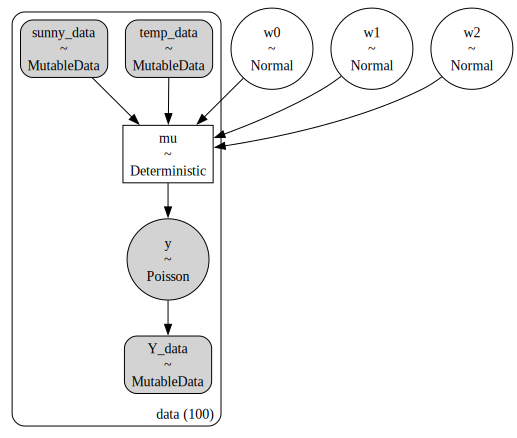

In [249]:
g = pm.model_to_graphviz(poisson_model)
display(g)

In [229]:
with poisson_model:
    trace = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=3000,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w0, w1, w2]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,-0.791,0.245,-1.240,-0.327,0.005,0.003,2848.0,3161.0,1.0
w1,-0.591,0.170,-0.911,-0.278,0.003,0.002,4537.0,4563.0,1.0
w2,0.083,0.010,0.064,0.103,0.000,0.000,2903.0,3173.0,1.0


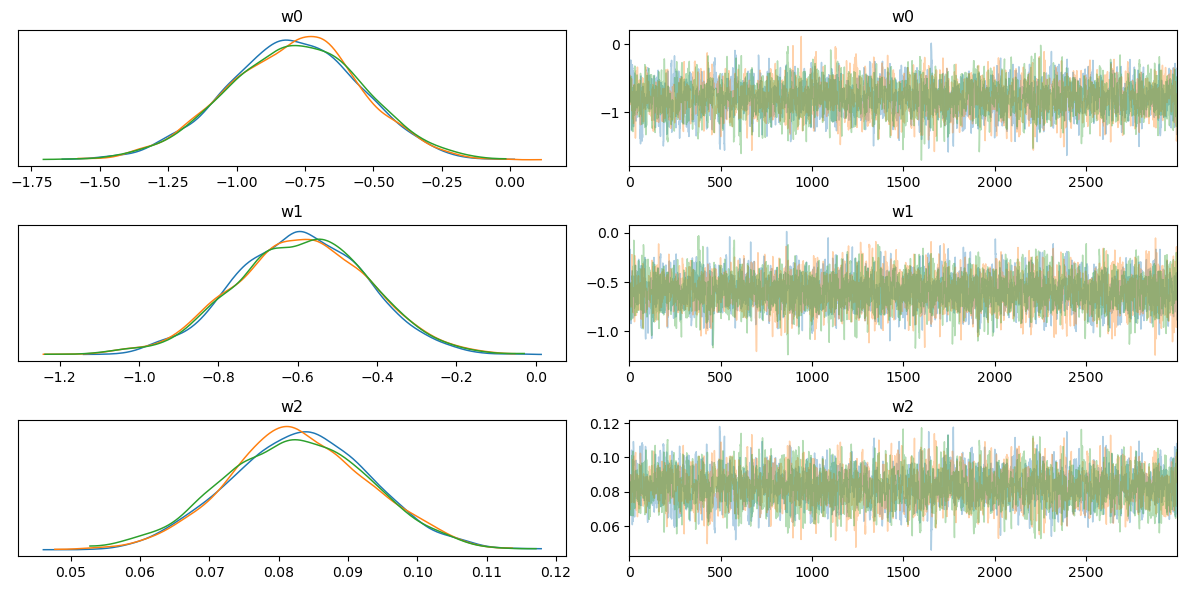

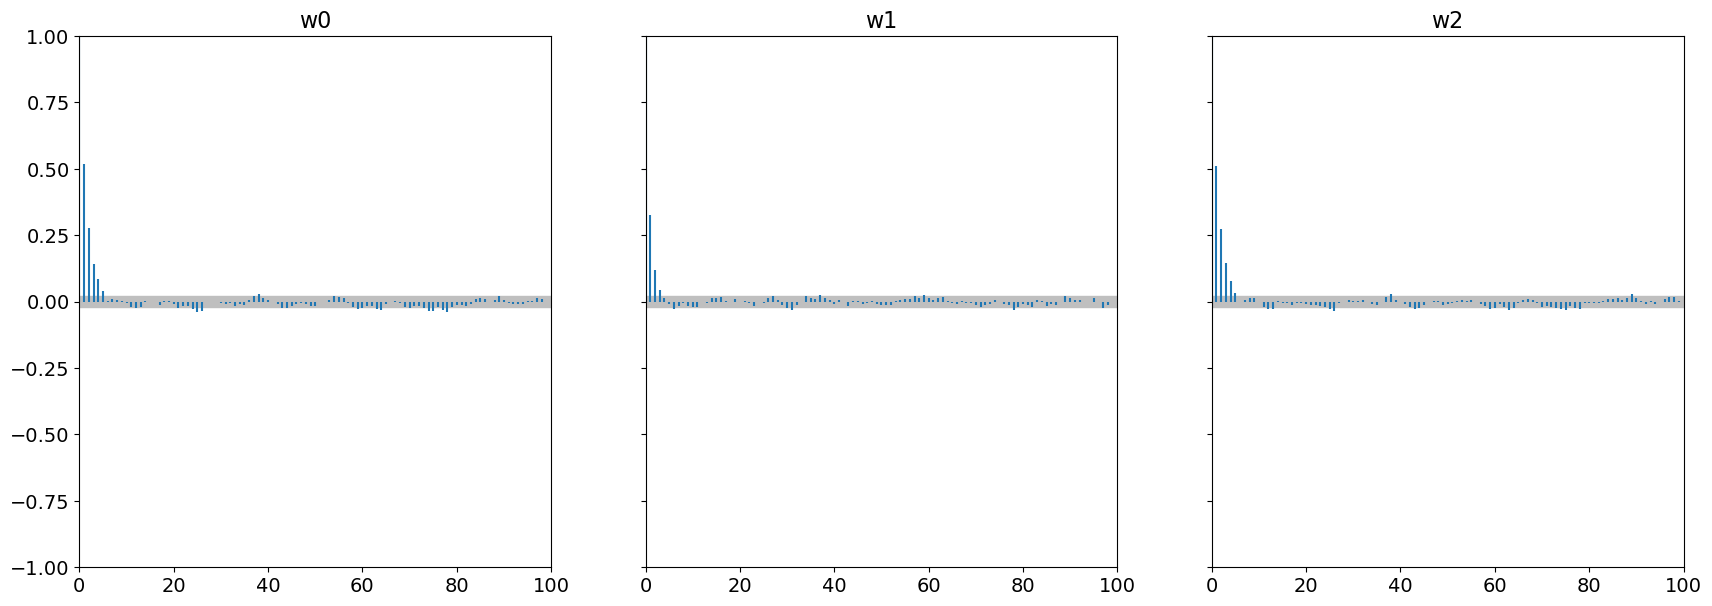

In [230]:
summary = az.summary(trace, var_names=["w0", "w1", "w2"])
display(summary)

az.plot_trace(trace, var_names=["w0", "w1", "w2"], compact=False)
plt.tight_layout()

az.plot_autocorr(trace, var_names=["w0", "w1", "w2"], combined=True)
plt.show()

事後分布は次のようになる。

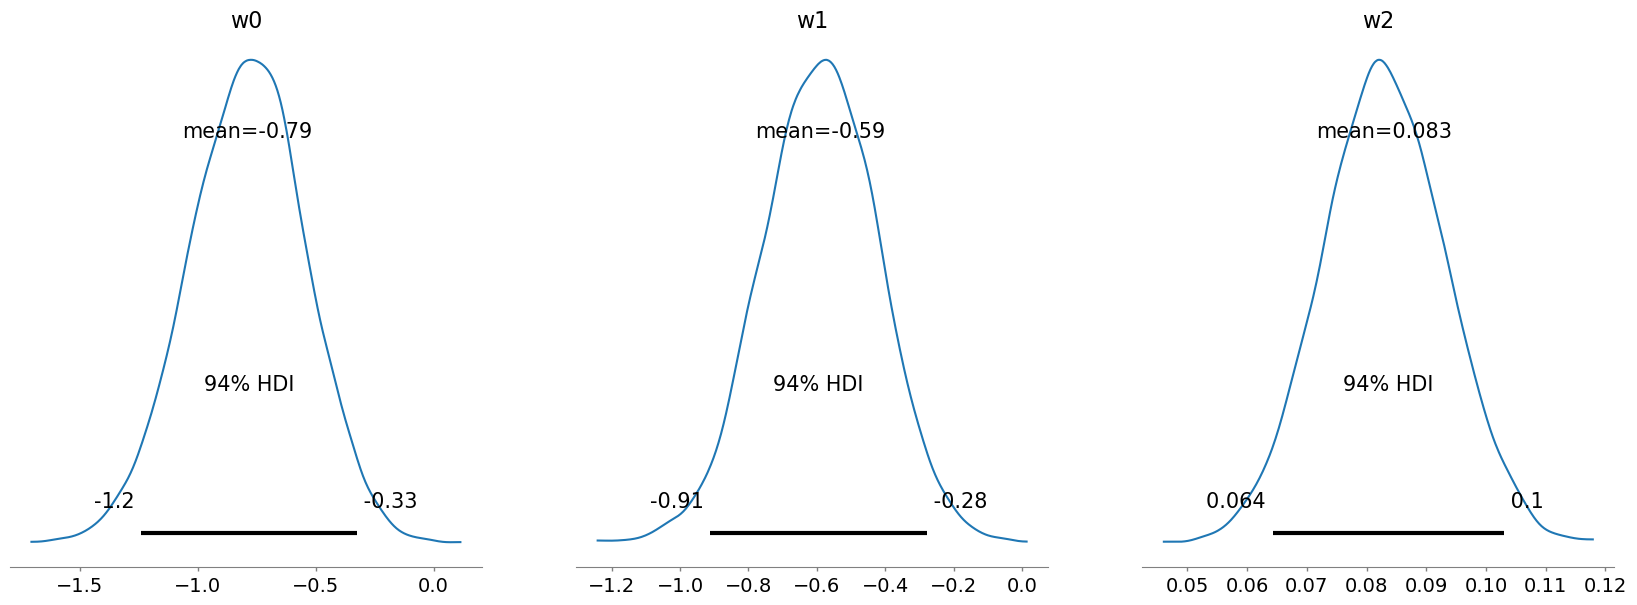

In [231]:
plt.rcParams['figure.figsize'] = (6, 6)
ax = az.plot_posterior(trace, var_names=["w0", "w1", "w2"])

ポアソンモデルでは線形予測子を指数関数によって非線形変換しているため、回帰係数の解釈が異なる。晴れの日と曇りの日では$\lambda$は次のようになる。
$$
晴れの日 \quad \lambda = \exp(w_0 + w_1 + w_2x_2) = \exp(w_0)\exp(w_1)\exp(w_2x_2) \\
曇りの日 \quad \lambda = \exp(w_0 + w_2x_2) = \exp(w_0)\exp(w_2x_2) \\
$$
よって晴れの日は曇りの日に比べ、$\exp(w_2)$倍だけ釣れた数が増加する。$w_1$の期待値は-0.59なので、$\exp(-0.59)=0.55$となり、晴れの日は曇りの日のおおよそ半分しか釣れないと解釈できる。

### 信用区間付き回帰曲線と予測信用区間
線形モデル同様信用区間付き回帰曲線と予測信用区間を可視化する。ポアソンモデルでは指数関数による非線形変換があるため、回帰直線ではなく回帰曲線となる。

In [233]:
temp_test = np.tile(np.linspace(temp.min(), temp.max(), 100), 2)
sunny_test = np.array([1]*100 + [0]*100)
sunny_idx = 100

In [235]:
pred_model = pm.Model()
with pred_model:
    pred_model.add_coord("data", values=range(len(temp_test)), mutable=True)
    # X, Yの観測値をMutableDataとして定義
    temp_data = pm.MutableData('temp_data', temp_test)
    sunny_data = pm.MutableData('sunny_data', sunny_test)

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w2 = pm.Normal("w2", mu=0, sigma=20)

    # 期待値lambdaの計算
    # pm.math.expによって線形予測子を非線形変換
    mu = pm.Deterministic("mu", pm.math.exp(w0 + w1 * sunny_data + w2 * temp_data))

    # 観測値が従う確率分布の定義
    y_pred = pm.Poisson('y_pred', mu=mu)
    
    prediction = pm.sample_posterior_predictive(trace, var_names=["y_pred", "mu"], predictions=True).predictions

Sampling: [y_pred]


In [236]:
sunnies = fish_nums[fish_nums.weather == "sunny"]
cloudies = fish_nums[fish_nums.weather == "cloudy"]

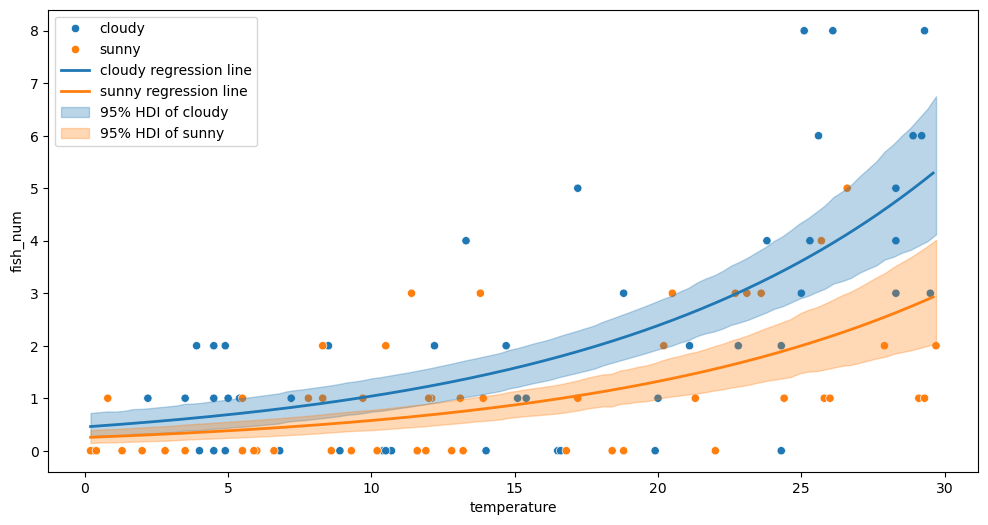

In [244]:
temp_values = np.arange(temp.min(), temp.max(), 0.1)
cmap = plt.get_cmap("tab10")
# 平均回帰曲線の計算 指数関数で変換する
w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1
w2_mean = summary['mean'].w2
sunny_mean = np.exp(w0_mean + w1_mean + w2_mean * temp_values)
cloudy_mean = np.exp(w0_mean + w2_mean * temp_values)

# 各天気の気温データ
sunny_temp = temp_test[:sunny_idx]
cloudy_temp = temp_test[sunny_idx:]

# 各天気の95% HDIの計算
hdis = az.hdi(prediction, hdi_prob=0.95)["mu"].values
hdi_sunny = hdis[:sunny_idx]
hdi_cloudy = hdis[sunny_idx:]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='temperature', y='fish_num', data=fish_nums, hue="weather", ax=axes)    # 観測値の散布図

#各天気の回帰曲線
axes.plot(temp_values, cloudy_mean, lw=2, c=cmap(0), label='cloudy regression line')
axes.plot(temp_values, sunny_mean, lw=2, c=cmap(1), label='sunny regression line')


# 各天気の95% HDI
axes.fill_between(cloudy_temp, y1=hdi_cloudy[:,0], y2=hdi_cloudy[:,1], color=cmap(0), alpha=0.30, label="95% HDI of cloudy")
axes.fill_between(sunny_temp, y1=hdi_sunny[:,0], y2=hdi_sunny[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunny")
plt.legend()
plt.show()

図でわかるように曇りの日の方がおおよそ倍多く釣れる。

さらに予測信用区間を描く。

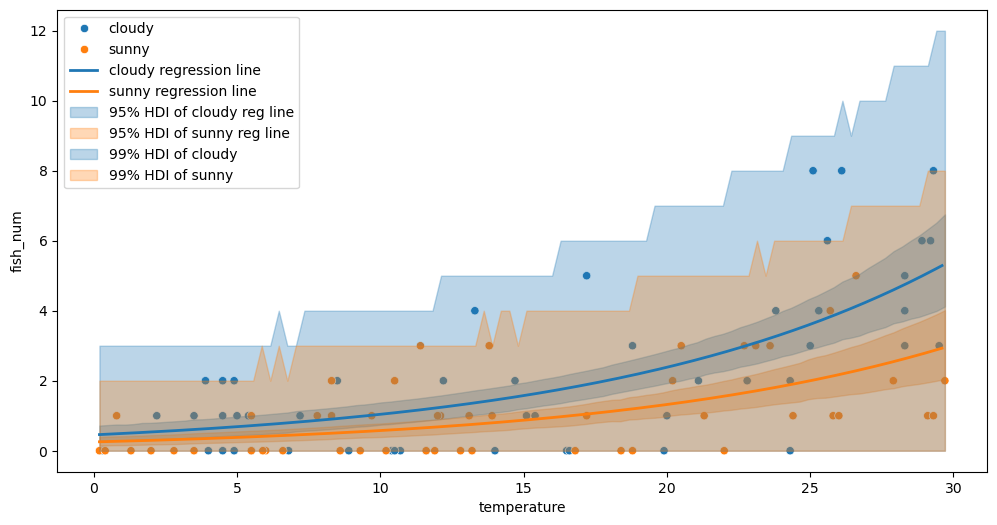

In [247]:
temp_values = np.arange(temp.min(), temp.max(), 0.1)
cmap = plt.get_cmap("tab10")

# 平均回帰曲線の計算 指数関数で変換する
w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1
w2_mean = summary['mean'].w2
sunny_mean = np.exp(w0_mean + w1_mean + w2_mean * temp_values)
cloudy_mean = np.exp(w0_mean + w2_mean * temp_values)

# 各天気の気温データ
sunny_temp = temp_test[:sunny_idx]
cloudy_temp = temp_test[sunny_idx:]

# 各天気の予測分布の95% HDIの計算
hdis = az.hdi(prediction, hdi_prob=0.99)["y_pred"].values
hdi_sunny_pred = hdis[:sunny_idx]
hdi_cloudy_pred = hdis[sunny_idx:]


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='temperature', y='fish_num', data=fish_nums, hue="weather", ax=axes)    # 観測値の散布図

#各天気の回帰曲線
axes.plot(temp_values, cloudy_mean, lw=2, c=cmap(0), label='cloudy regression line')
axes.plot(temp_values, sunny_mean, lw=2, c=cmap(1), label='sunny regression line')

axes.fill_between(cloudy_temp, y1=hdi_cloudy[:,0], y2=hdi_cloudy[:,1], color=cmap(0), alpha=0.30, label="95% HDI of cloudy reg line")
axes.fill_between(sunny_temp, y1=hdi_sunny[:,0], y2=hdi_sunny[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunny reg line")

# 各天気の95% HDI
axes.fill_between(cloudy_temp, y1=hdi_cloudy_pred[:,0], y2=hdi_cloudy_pred[:,1], color=cmap(0), alpha=0.30, label="99% HDI of cloudy")
axes.fill_between(sunny_temp, y1=hdi_sunny_pred[:,0], y2=hdi_sunny_pred[:,1], color=cmap(1), alpha=0.30, label="99% HDI of sunny")
plt.legend()
plt.show()

これを見ると、データは99%信用区間の中に収まっていることがわかる。

## pystanでの実装

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
fish_nums = pd.read_csv('../data/2-4-fish-num.csv')

In [5]:
fish_nums

,fish_num,weather,temperature
0,0,cloudy,5.5
1,2,cloudy,21.1
2,5,cloudy,17.2
3,1,cloudy,5.0
4,3,cloudy,28.3
...,...,...,...
95,0,sunny,5.9
96,0,sunny,12.8
97,0,sunny,2.8
98,0,sunny,3.5


In [41]:
y = fish_nums['fish_num'].values
N = len(y)
temp = fish_nums['temperature'].values.reshape(-1, 1)
weather = (fish_nums['weather']=="sunny").values.astype(int).reshape(-1, 1)
X = np.concatenate([np.ones((N, 1)), weather, temp], axis=1)
K = X.shape[1]

temp_pred = np.tile(np.linspace(temp.min(), temp.max(), 100), 2).reshape(-1, 1)
weather_pred = np.array([1]*100 + [0]*100).reshape(-1, 1)
X_pred = np.concatenate([np.ones((200, 1)), weather_pred, temp_pred], axis=1)
N_pred = len(X_pred)

In [54]:
stan_data = {
    "N": N,
    "K": K,
    "X": X,
    "y": y,
    "N_pred": N_pred,
    "X_pred": X_pred
}

In [53]:
with open('../stan/2-4-poisson-model.stan') as f:
    stan_code = f.read()

In [55]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [37]:
fit = sm.sample(num_chains=3, num_samples=6000, num_warmup=1000, num_thin=2)

Sampling:   0%
Sampling:  33% (7000/21000)
Sampling:  67% (14000/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 9.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.797,0.24,-1.239,-0.344,0.003,0.002,6241.0,6487.0,1.0
beta[1],-0.594,0.17,-0.910,-0.274,0.002,0.001,7096.0,6906.0,1.0
beta[2],0.083,0.01,0.064,0.102,0.000,0.000,6296.0,6060.0,1.0


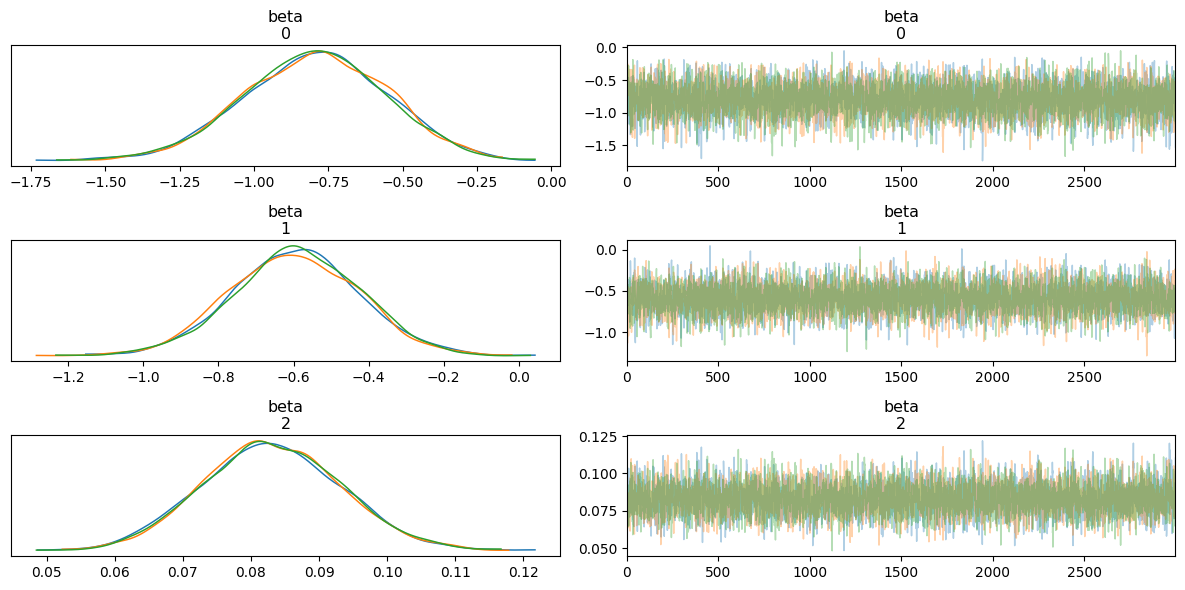

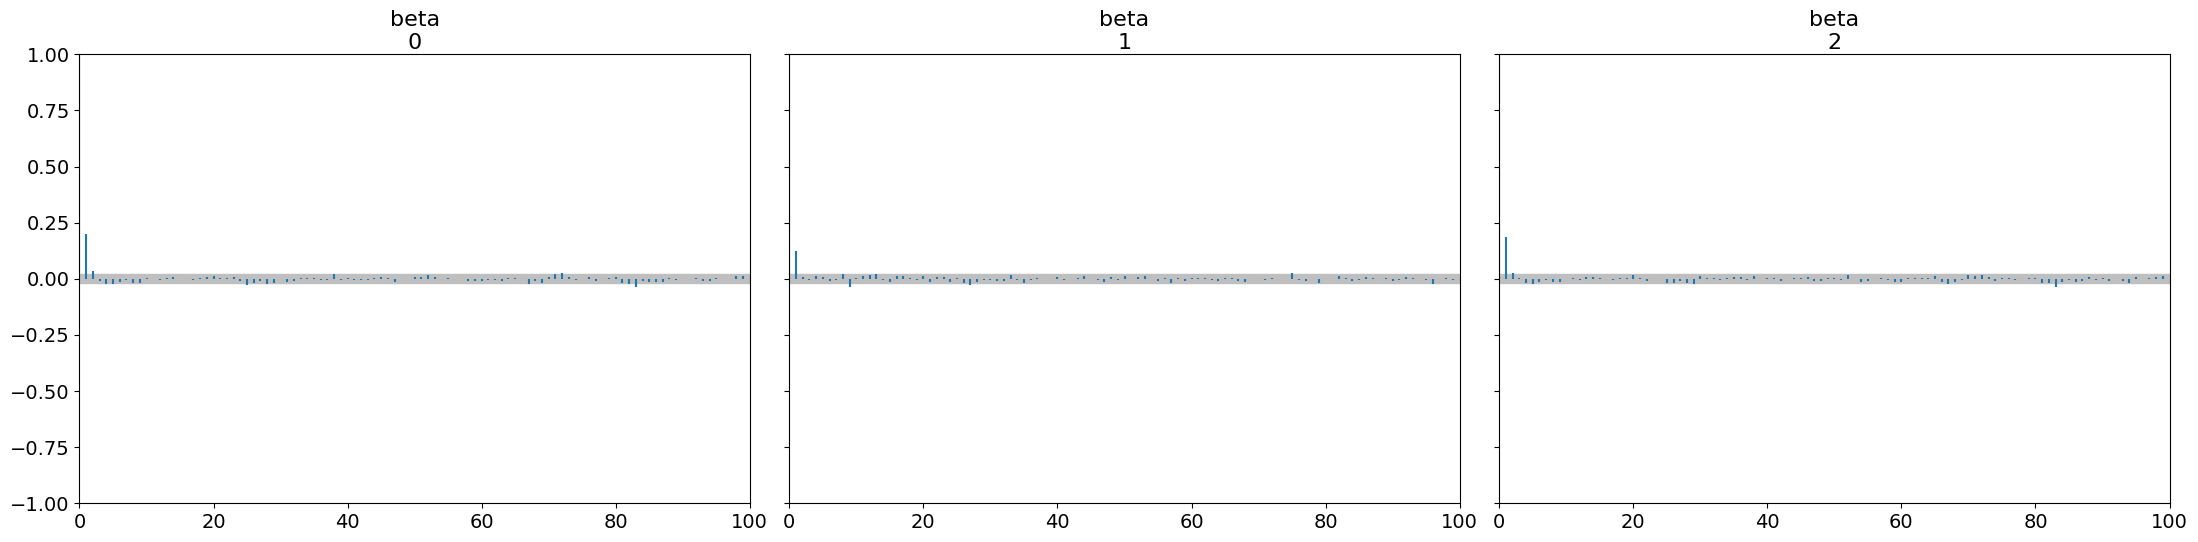

In [38]:
summary = az.summary(fit, var_names=["beta"])
display(summary)
az.plot_trace(fit, var_names=["beta"], compact=False)
plt.tight_layout()

az.plot_autocorr(fit, var_names=["beta"], combined=True)
plt.tight_layout()

In [43]:
temp_values = X_pred[:100, -1]
sunny_idx = X_pred[:, 1]==1
cloudy_idx = X_pred[:, 1]==0

sunny_X = X_pred[sunny_idx]
cloudy_X = X_pred[cloudy_idx]

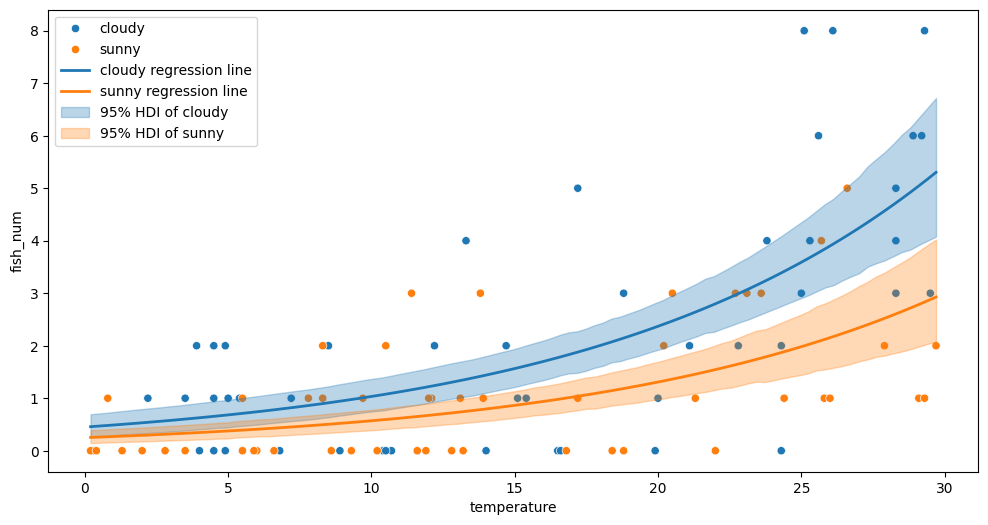

In [50]:
cmap = plt.get_cmap("tab10")
# 平均回帰曲線の計算 指数関数で変換する
beta = summary["mean"][summary.index.str.contains("beta")].values
sunny_mean = np.exp(np.dot(sunny_X, beta))
cloudy_mean = np.exp(np.dot(cloudy_X, beta))

# 各天気の95% HDIの計算
hdis = az.hdi(fit, hdi_prob=0.95)["lambda_pred"].values
hdi_sunny = hdis[sunny_idx]
hdi_cloudy = hdis[cloudy_idx]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='temperature', y='fish_num', data=fish_nums, hue="weather", ax=axes)    # 観測値の散布図

#各天気の回帰曲線
axes.plot(temp_values, cloudy_mean, lw=2, c=cmap(0), label='cloudy regression line')
axes.plot(temp_values, sunny_mean, lw=2, c=cmap(1), label='sunny regression line')


# 各天気の95% HDI
axes.fill_between(temp_values, y1=hdi_cloudy[:,0], y2=hdi_cloudy[:,1], color=cmap(0), alpha=0.30, label="95% HDI of cloudy")
axes.fill_between(temp_values, y1=hdi_sunny[:,0], y2=hdi_sunny[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunny")
plt.legend()
plt.show()

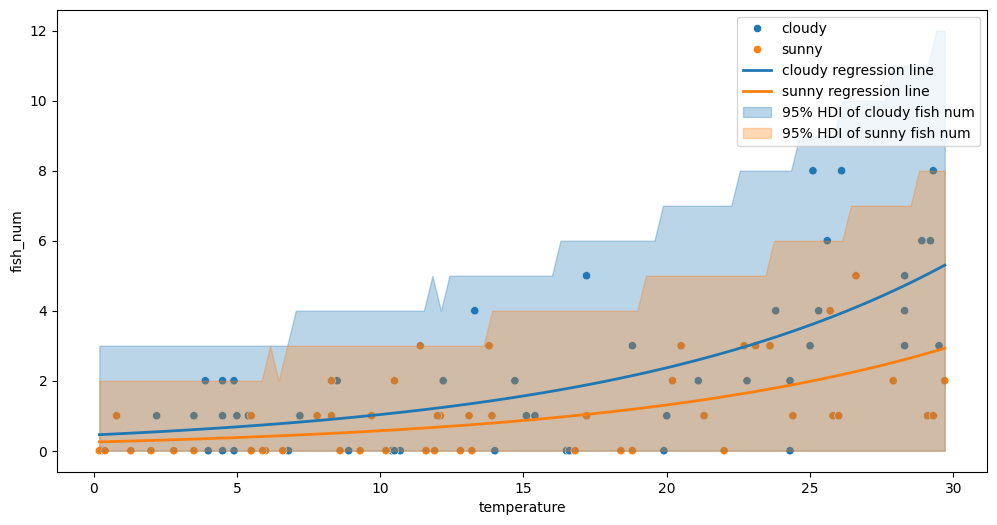

In [52]:
cmap = plt.get_cmap("tab10")
# 平均回帰曲線の計算 指数関数で変換する
beta = summary["mean"][summary.index.str.contains("beta")].values
sunny_mean = np.exp(np.dot(sunny_X, beta))
cloudy_mean = np.exp(np.dot(cloudy_X, beta))

# 各天気の95% HDIの計算
hdis = az.hdi(fit, hdi_prob=0.99)["y_pred"].values
hdi_sunny = hdis[sunny_idx]
hdi_cloudy = hdis[cloudy_idx]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='temperature', y='fish_num', data=fish_nums, hue="weather", ax=axes)    # 観測値の散布図

#各天気の回帰曲線
axes.plot(temp_values, cloudy_mean, lw=2, c=cmap(0), label='cloudy regression line')
axes.plot(temp_values, sunny_mean, lw=2, c=cmap(1), label='sunny regression line')


# 各天気の95% HDI
axes.fill_between(temp_values, y1=hdi_cloudy[:,0], y2=hdi_cloudy[:,1], color=cmap(0), alpha=0.30, label="95% HDI of cloudy fish num")
axes.fill_between(temp_values, y1=hdi_sunny[:,0], y2=hdi_sunny[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunny fish num")
plt.legend()
plt.show()